# Demo
Demo of this thesis experiment.

## Import and Prepare
Import the necessary modules and some preparations

In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from skimage import io
import cv2 as cv
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

from samples.fish import fish

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

EXAMPLE_IMAGE = "七星斑.jpg"

Using TensorFlow backend.


## Configurations
Configurations are defined in fish.py

In [2]:
config = fish.FishConfig()
#FISH_DIR = os.path.join(ROOT_DIR, "datasets/fish")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preference

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

## Load Model

In [5]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
# Set path to fish weights file

# weights_path = "/path/to/mask_rcnn_fish.h5"
weights_path =  "../../mask_rcnn_fish_0500.h5"

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ../../mask_rcnn_fish_0500.h5


## Detect and Crop Image

In [7]:
def detect_and_crop(model, image_path=None):
    assert image_path

    if image_path:
        # Run model detection and generate cropped image
        print("Running on {}".format(image_path))
        # Read image
        image = skimage.io.imread(image_path)

        # get filename
        #base = os.path.basename(args.image)
        #filename = os.path.splitext(base)[0]
        filename = os.path.splitext(image_path)[0]

        # Detect objects
        r = model.detect([image], verbose=1)[0]

        # if no any mask
        if r['masks'].shape[2] <= 0:
            print("detect no fish")
            return

        for index in range(r['masks'].shape[2]):
            print("cropping region ", index)
            mask = r['masks'].astype(np.uint8) * 255
            masked = cv.bitwise_and(image, image, mask=mask[:, :, index])
            cropped = masked[r['rois'][index][0]:r['rois'][index][2], r['rois'][index][1]:r['rois'][index][3]]
            outputfile = filename + "_" + str(index) + ".bmp"
            io.imsave(outputfile, cropped)


In [8]:
detect_and_crop(model, EXAMPLE_IMAGE)

Running on 七星斑.jpg
Processing 1 images
image                    shape: (1000, 1333, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1333.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
cropping region  0


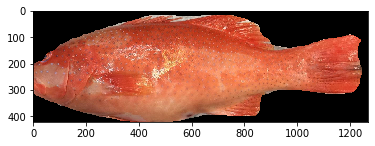

In [9]:
cropped = skimage.io.imread('七星斑_0.bmp')
plt.imshow(cropped)
plt.show()

## Classification Part Preparation

In [10]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image

IMAGE_SIZE = (224, 224)

classlist_filename='classlist.txt'
labellist=[]
with open(classlist_filename, 'r', encoding='utf-8') as file:
  while True:
    line=file.readline()
    if len(line)==0: break
    line=line.strip()
    labellist.append(line)
net = load_model('model_config.h5')

# 41 classes
cls_list = ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
    '1', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
    '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
    '3', '40', '41', '4', '5', '6', '7', '8', '9']

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Prediction of Each Image

In [11]:
files = ['七星斑_0.bmp']

for f in files:
    img = image.load_img(f, target_size=(net.input_shape[1], net.input_shape[2]))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    print(f)
    for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], labellist[i]))

七星斑_0.bmp
    1.000  15_Serranidae_鮨科_Plectropomus_刺鰓鮨屬_Plectropomus leopardus_花斑刺鰓鮨_七星斑
    0.000  31_Scorpaenidae_鮋科_cirrosa_鬚擬鮋_石狗公
    0.000  6_Priacanthidae_大眼鯛科_紅目鰱
    0.000  29_Lutjanidae_笛鯛科_赤筆
    0.000  12_Sparidae_鯛科_Pagrus_major_真鯛_嘉鱲魚
